<a href="https://colab.research.google.com/github/DiNOV-Tokyo/yolov5/blob/main/DL_torchvsion_DCGAN_oxford102.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 現場で使える！　PyTorchPyTorch開発入門


##翔泳社

## 1.1 Google Drive をマウント

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My\ Drive/Colab\ Notebooks
#%mkdir yolo_train
%cd yolo_train

/content/drive/My Drive/Colab Notebooks
/content/drive/My Drive/Colab Notebooks/yolo_train


## 1.2 モジュール読み込み

In [ ]:
!pip install pytorch

  Using cached pytorch-1.0.2.tar.gz (689 bytes)
  ERROR: Failed building wheel for pytorch
  Running setup.py clean for pytorch
Failed to build pytorch
    Running setup.py install for pytorch ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-_ll0socw/pytorch_1d6f13c2ca1f4e309c9aa291eefb437e/setup.py'"'"'; __file__='"'"'/tmp/pip-install-_ll0socw/pytorch_1d6f13c2ca1f4e309c9aa291eefb437e/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-16i90gxh/install-record.txt --single-version-externally-managed --compile --install-headers /usr/local/include/python3.7/pytorch Check the logs for full command output.


In [ ]:
!pwd

/content


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
import time

import numpy as np
from tqdm import tqdm
from PIL import Image
import os
import copy

#from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader
from torchvision.utils import save_image

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

# GPU/CPUが使えるかどうか確認
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

PyTorch Version:  1.9.0+cu102
Torchvision Version:  0.10.0+cu102
Setup complete. Using torch 1.9.0+cu102 _CudaDeviceProperties(name='Tesla K80', major=3, minor=7, total_memory=11441MB, multi_processor_count=13)


device(type='cuda', index=0)

##DCGANによる画像生成

Oxford 12 Flower Dataset

In [4]:
!wget http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
!tar xf 102flowers.tgz
!mkdir oxford-102
!mkdir oxford-102/jpg
!mv jpg/*.jpg oxford-102/jpg

--2021-09-19 10:43:13--  http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz [following]
--2021-09-19 10:43:13--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344862509 (329M) [application/x-gzip]
Saving to: ‘102flowers.tgz’

102flowers.tgz      100%[===================>] 328.89M  23.2MB/s    in 16s     

2021-09-19 10:43:29 (20.9 MB/s) - ‘102flowers.tgz’ saved [344862509/344862509]



In [5]:
img_data = ImageFolder("oxford-102/",
    transform=transforms.Compose([
        transforms.Resize(80),
        transforms.CenterCrop(64),
        transforms.ToTensor()
]))

batch_size = 64
img_loader = DataLoader(img_data, batch_size=batch_size,
                        shuffle=True)

画像生成モデル

In [6]:
nz = 100
ngf = 32

class GNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 
                               4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4,
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2,
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf * 2, ngf,
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf, 3,
                               4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        out = self.main(x)
        return out

識別モデル

In [7]:
ndf = 32

class DNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
        )

    def forward(self, x):
        out = self.main(x)
        return out.squeeze()

訓練関数の作成

In [8]:
d = DNet().to("cuda:0")
g = GNet().to("cuda:0")

# Adamのパラメータは元論文の提案値
opt_d = optim.Adam(d.parameters(),
    lr=0.0002, betas=(0.5, 0.999))
opt_g = optim.Adam(g.parameters(),
    lr=0.0002, betas=(0.5, 0.999))

# クロスエントロピーを計算するための補助変数など
ones = torch.ones(batch_size).to("cuda:0")
zeros = torch.zeros(batch_size).to("cuda:0")
loss_f = nn.BCEWithLogitsLoss()

# モニタリング用のz
fixed_z = torch.randn(batch_size, nz, 1, 1).to("cuda:0")

In [9]:
from statistics import mean

def train_dcgan(g, d, opt_g, opt_d, loader):
    # 生成モデル、識別モデルの目的関数の追跡用の配列
    log_loss_g = []
    log_loss_d = []
    for real_img, _ in tqdm(loader):
        batch_len = len(real_img)
        
         # 実際の画像をGPUにコピー
        real_img = real_img.to("cuda:0")
        
         # 偽画像を乱数と生成モデルから作る
        z = torch.randn(batch_len, nz, 1, 1).to("cuda:0")
        fake_img = g(z)
        
        # 後で使用するので偽画像の値のみ取り出しておく
        fake_img_tensor = fake_img.detach()
        
        # 偽画像に対する生成モデルの評価関数を計算する
        out = d(fake_img)
        loss_g = loss_f(out, ones[: batch_len])
        log_loss_g.append(loss_g.item())
        
        # 計算グラフが生成モデルと識別モデルの両方に
        # 依存しているので両者とも勾配をクリアしてから
        # 微分の計算とパラメータ更新を行う
        d.zero_grad(), g.zero_grad()
        loss_g.backward()
        opt_g.step()

        # 実際の画像に対する識別モデルの評価関数を計算
        real_out = d(real_img)
        loss_d_real = loss_f(real_out, ones[: batch_len])
        
        # PyTorchでは同じTensorを含んだ計算グラフに対して
        # 2回backwardを行うことができないので保存してあった
        # Tensorを使用して無駄な計算を省く
        fake_img = fake_img_tensor
        
        # 偽画像に対する識別モデルの評価関数の計算
        fake_out = d(fake_img_tensor)
        loss_d_fake = loss_f(fake_out, zeros[: batch_len])
        
        # 実偽の評価関数の合計値
        loss_d = loss_d_real + loss_d_fake
        log_loss_d.append(loss_d.item())
        
        # 識別モデルの微分計算とパラメータ更新
        d.zero_grad(), g.zero_grad()
        loss_d.backward()
        opt_d.step()
        
    return mean(log_loss_g), mean(log_loss_d)

訓練開始

In [13]:
import datetime

for epoch in range(150):
    train_dcgan(g, d, opt_g, opt_d, img_loader)
    # 10回の繰り返しごとに学習結果を保存する
    print("{} Epoch {}: ".format(datetime.datetime.now(), epoch))
    if epoch % 10 == 0:
        # パラメータの保存
        torch.save(
            g.state_dict(),
            "oxford-102/g_{:03d}.prm".format(epoch),
            pickle_protocol=4)
        torch.save(
            d.state_dict(),
            "oxford-102/d_{:03d}.prm".format(epoch),
            pickle_protocol=4)
        # モニタリング用のzから生成した画像を保存
        generated_img = g(fixed_z)
        save_image(generated_img,
                   "oxford-102/{:03d}.jpg".format(epoch))

100%|██████████| 128/128 [01:35<00:00,  1.33it/s]


2021-09-19 10:55:14.193407 Epoch 0: 


 30%|██▉       | 38/128 [00:27<01:05,  1.38it/s]


KeyboardInterrupt: ignored

結果の表示

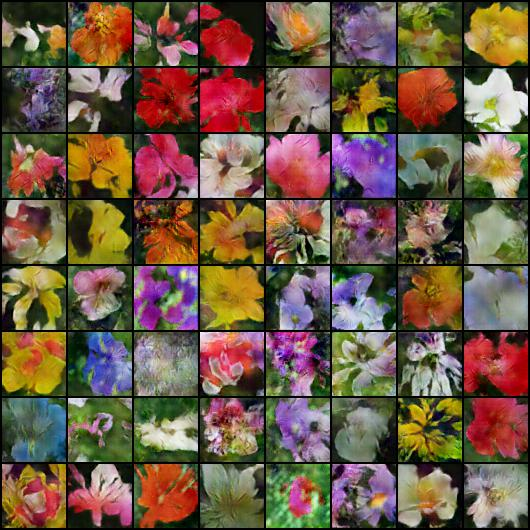

In [ ]:
from IPython.display import Image,display_jpeg
display_jpeg(Image('oxford-102/150.jpg'))

In [ ]:
!ls -all

total 337172
drwsrwsr-x 1 jovyan users      4096 Sep  4 21:50 .
drwxr-xr-x 1 root   root       4096 Sep  3 12:01 ..
-rw-r--r-- 1 jovyan users 344862509 Feb 20  2009 102flowers.tgz
-rw-rw-r-- 1 jovyan users       220 Feb 25  2020 .bash_logout
-rw-rw-r-- 1 jovyan users      3823 Sep  3 12:01 .bashrc
drwsrwsr-x 1 jovyan users      4096 Sep  5 00:01 .cache
drwsrwsr-x 1 jovyan users      4096 Sep  3 12:02 .conda
drwxr-sr-x 1 jovyan users      4096 Sep  4 01:04 FashionMNIST
drwxr-sr-x 1 jovyan users      4096 Sep  4 00:53 .ipynb_checkpoints
drwxr-sr-x 1 jovyan users      4096 Sep  4 00:53 .ipython
drwxr-sr-x 2 jovyan users    274432 Sep  4 21:50 jpg
drwsrws--- 1 jovyan users      4096 Sep  4 01:38 .jupyter
drwxr-sr-x 1 jovyan users      4096 Sep  4 00:53 .local
drwsrwsr-x 2 jovyan users      4096 Sep  3 12:02 .npm
drwx--S--- 3 jovyan users      4096 Sep  4 01:11 .nv
drwxr-sr-x 3 jovyan users      4096 Sep  4 23:47 oxford-102
-rw-rw-r-- 1 jovyan users       807 Feb 25  2020 .profile
-rw-r--r-